In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from typing import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=2)

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [5]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

conn = sqlite3.connect(":memory:", check_same_thread=False)  
memory = SqliteSaver(conn)

In [6]:
class Agent:
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [7]:
prompt = """You are a knowledgeable research assistant with access to \
a search engine. Use it efficiently to find relevant information. Make \ 
multiple search queries as needed, either simultaneously or in sequence, \
to gather accurate results. Only perform searches when you're confident about what you need. \
If additional information is required before asking follow-up questions, \
you can initiate further searches to clarify."""

prompt

"You are a knowledgeable research assistant with access to a search engine. Use it efficiently to find relevant information. Make \\ \nmultiple search queries as needed, either simultaneously or in sequence, to gather accurate results. Only perform searches when you're confident about what you need. If additional information is required before asking follow-up questions, you can initiate further searches to clarify."

In [8]:
model = ChatOpenAI(model="gpt-4o")
ag = Agent(model, [tool], system=prompt, checkpointer=memory)

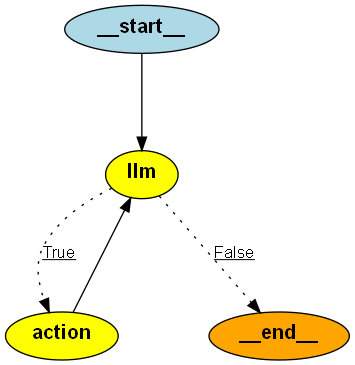

In [9]:
from IPython.display import Image

Image(ag.graph.get_graph().draw_png())

In [10]:
messages = [HumanMessage(content="What is the weather like in Taranto?")]

In [11]:
thread = {"configurable": {"thread_id": "1"}}

In [12]:
for event in ag.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v['messages'])

{'messages': [HumanMessage(content='What is the weather like in Taranto?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_16sC0tHf6JAe4BotHfSLZhQv', 'function': {'arguments': '{"query":"current weather in Taranto"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 159, 'total_tokens': 181, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-078e9d95-05e1-4b08-9e55-e6e93e1e84b9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Taranto'}, 'id': 'call_16sC0tHf6JAe4BotHfSLZhQv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 159, 'output_tokens': 22, 'total_tokens': 181})]}
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id'

In [13]:
messages = [HumanMessage(content="What about in Martina Franca?")]
thread = {"configurable": {"thread_id": "1"}}
for event in ag.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='What is the weather like in Taranto?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_16sC0tHf6JAe4BotHfSLZhQv', 'function': {'arguments': '{"query":"current weather in Taranto"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 159, 'total_tokens': 181, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-078e9d95-05e1-4b08-9e55-e6e93e1e84b9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Taranto'}, 'id': 'call_16sC0tHf6JAe4BotHfSLZhQv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 159, 'output_tokens': 22, 'total_tokens': 181}), ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\'

In [14]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "1"}}
for event in ag.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='What is the weather like in Taranto?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_16sC0tHf6JAe4BotHfSLZhQv', 'function': {'arguments': '{"query":"current weather in Taranto"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 159, 'total_tokens': 181, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-078e9d95-05e1-4b08-9e55-e6e93e1e84b9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Taranto'}, 'id': 'call_16sC0tHf6JAe4BotHfSLZhQv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 159, 'output_tokens': 22, 'total_tokens': 181}), ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\'

In [15]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "2"}}
for event in ag.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Which one is warmer?', additional_kwargs={}, response_metadata={}), AIMessage(content='To provide an accurate answer, I need to know the specific items or locations you want to compare in terms of warmth. Could you please specify the two things you want to compare?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 155, 'total_tokens': 192, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'stop', 'logprobs': None}, id='run-8270f177-fee2-40a1-9f22-8d1850bf988a-0', usage_metadata={'input_tokens': 155, 'output_tokens': 37, 'total_tokens': 192})]}
{'messages': [AIMessage(content='To provide an accurate answer, I need to know the specific items or locations you want to compare in terms of warmth. Could you please specify the two things you want to compare?', additional_kwargs={'refusal': None}, r

## Flow control

In [16]:
class Agent_control:
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer, 
            interrupt_before=["action"] # addition
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [17]:
conn_control = sqlite3.connect(":memory:", check_same_thread=False)  
memory_control = SqliteSaver(conn_control)

In [18]:
ag_control = Agent_control(model, [tool], system=prompt, checkpointer=memory_control)

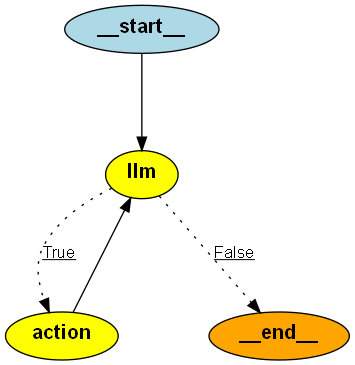

In [19]:
Image(ag_control.graph.get_graph().draw_png())

In [20]:
messages = [HumanMessage(content="What is the weather like in Taranto?")]
thread = {"configurable": {"thread_id": "1"}}
for event in ag_control.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='What is the weather like in Taranto?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7LgoF3RRnbZ6dDmhqYFEZvux', 'function': {'arguments': '{"query":"current weather in Taranto"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 159, 'total_tokens': 181, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a16d4ce1-e702-4af8-8b59-a74db544f95a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Taranto'}, 'id': 'call_7LgoF3RRnbZ6dDmhqYFEZvux', 'type': 'tool_call'}], usage_metadata={'input_tokens': 159, 'output_tokens': 22, 'total_tokens': 181})]}
{'messages': [AIMessage(content='', additional_kwargs={'tool_c

In [21]:
ag_control.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='What is the weather like in Taranto?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7LgoF3RRnbZ6dDmhqYFEZvux', 'function': {'arguments': '{"query":"current weather in Taranto"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 159, 'total_tokens': 181, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a16d4ce1-e702-4af8-8b59-a74db544f95a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Taranto'}, 'id': 'call_7LgoF3RRnbZ6dDmhqYFEZvux', 'type': 'tool_call'}], usage_metadata={'input_tokens': 159, 'output_tokens': 22, 'total_tokens': 181})]}, next=('action',), config={'configurable'

In [22]:
ag_control.graph.get_state(thread).next

('action',)

### Continue after interrupt

In [23]:
for event in ag_control.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Taranto'}, 'id': 'call_7LgoF3RRnbZ6dDmhqYFEZvux', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Taranto\', \'region\': \'Puglia\', \'country\': \'Italy\', \'lat\': 40.48, \'lon\': 17.23, \'tz_id\': \'Europe/Rome\', \'localtime_epoch\': 1726472488, \'localtime\': \'2024-09-16 09:41\'}, \'current\': {\'last_updated_epoch\': 1726471800, \'last_updated\': \'2024-09-16 09:30\', \'temp_c\': 19.3, \'temp_f\': 66.7, \'is_day\': 1, \'condition\': {\'text\': \'Partly cloudy\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/116.png\', \'code\': 1003}, \'wind_mph\': 14.5, \'wind_kph\': 23.4, \'wind_degree\': 322, \'wind_dir\': \'NW\', \'pressure_mb\': 1011.0, \'pressure_in\': 29.85, \'precip_mm\': 0.01, \'precip_in\': 0.0, \'humidity\': 64, \'cloud\': 25, \'feelslike_c\': 19.3, \'feelslike_f\': 6

In [24]:
ag_control.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='What is the weather like in Taranto?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7LgoF3RRnbZ6dDmhqYFEZvux', 'function': {'arguments': '{"query":"current weather in Taranto"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 159, 'total_tokens': 181, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a16d4ce1-e702-4af8-8b59-a74db544f95a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Taranto'}, 'id': 'call_7LgoF3RRnbZ6dDmhqYFEZvux', 'type': 'tool_call'}], usage_metadata={'input_tokens': 159, 'output_tokens': 22, 'total_tokens': 181}), ToolMessage(content='[{\'url\': \'https://

In [25]:
ag_control.graph.get_state(thread).next

()

The following block creates a user-controlled loop

In [26]:
messages = [HumanMessage("What is the weather like in Taranto?")]
thread = {"configurable": {"thread_id": "2"}}

for event in ag_control.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

while ag_control.graph.get_state(thread).next:
    print("\n", ag_control.graph.get_state(thread),"\n")
    _input = input("proceed?")
    if _input != "y":
        print("aborting")
        break
    for event in ag_control.graph.stream(None, thread):
        for v in event.values():
            print(v)

{'messages': [HumanMessage(content='What is the weather like in Taranto?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_E5BBLclaTtKhePufSa9gsU9E', 'function': {'arguments': '{"query":"current weather in Taranto"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 159, 'total_tokens': 181, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ed7ab95a-ac74-4a57-b3c3-b8e1d92f5fe8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Taranto'}, 'id': 'call_E5BBLclaTtKhePufSa9gsU9E', 'type': 'tool_call'}], usage_metadata={'input_tokens': 159, 'output_tokens': 22, 'total_tokens': 181})]}
{'messages': [AIMessage(content='', additional_kwargs={'tool_c

proceed? y


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Taranto'}, 'id': 'call_E5BBLclaTtKhePufSa9gsU9E', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Taranto\', \'region\': \'Puglia\', \'country\': \'Italy\', \'lat\': 40.48, \'lon\': 17.23, \'tz_id\': \'Europe/Rome\', \'localtime_epoch\': 1726472568, \'localtime\': \'2024-09-16 09:42\'}, \'current\': {\'last_updated_epoch\': 1726471800, \'last_updated\': \'2024-09-16 09:30\', \'temp_c\': 19.3, \'temp_f\': 66.7, \'is_day\': 1, \'condition\': {\'text\': \'Partly cloudy\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/116.png\', \'code\': 1003}, \'wind_mph\': 14.5, \'wind_kph\': 23.4, \'wind_degree\': 322, \'wind_dir\': \'NW\', \'pressure_mb\': 1011.0, \'pressure_in\': 29.85, \'precip_mm\': 0.01, \'precip_in\': 0.0, \'humidity\': 64, \'cloud\': 25, \'feelslike_c\': 19.3, \'feelslike_f\': 6

### Update state

In [27]:
messages = [HumanMessage("What is the weather like in Taranto?")]
thread = {"configurable": {"thread_id": "3"}}
for event in ag_control.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='What is the weather like in Taranto?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2hzL02paQtiKyjVCRpXpY9B4', 'function': {'arguments': '{"query":"current weather in Taranto"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 159, 'total_tokens': 181, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9990e040-dd60-485f-b320-7d5dc5dec014-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Taranto'}, 'id': 'call_2hzL02paQtiKyjVCRpXpY9B4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 159, 'output_tokens': 22, 'total_tokens': 181})]}
{'messages': [AIMessage(content='', additional_kwargs={'tool_c

In [28]:
current_values = ag_control.graph.get_state(thread)

In [29]:
current_values.values['messages'][-1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2hzL02paQtiKyjVCRpXpY9B4', 'function': {'arguments': '{"query":"current weather in Taranto"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 159, 'total_tokens': 181, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9990e040-dd60-485f-b320-7d5dc5dec014-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Taranto'}, 'id': 'call_2hzL02paQtiKyjVCRpXpY9B4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 159, 'output_tokens': 22, 'total_tokens': 181})

In [30]:
current_values.values['messages'][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Taranto'},
  'id': 'call_2hzL02paQtiKyjVCRpXpY9B4',
  'type': 'tool_call'}]

In [31]:
_id = current_values.values['messages'][-1].tool_calls[0]['id']
current_values.values['messages'][-1].tool_calls = [
    {'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Bari'},
  'id': _id,  'type': 'tool_call'}
]

In [32]:
current_values.values['messages'][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Bari'},
  'id': 'call_2hzL02paQtiKyjVCRpXpY9B4',
  'type': 'tool_call'}]

In [33]:
ag_control.graph.update_state(thread, current_values.values)

{'messages': [HumanMessage(content='What is the weather like in Taranto?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2hzL02paQtiKyjVCRpXpY9B4', 'function': {'arguments': '{"query":"current weather in Taranto"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 159, 'total_tokens': 181, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9990e040-dd60-485f-b320-7d5dc5dec014-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Taranto'}, 'id': 'call_2hzL02paQtiKyjVCRpXpY9B4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 159, 'output_tokens': 22, 'total_tokens': 181}), HumanMessage(content='What is the weather like in Taranto?', ad

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef73ff5-2e5a-6cfe-8002-422612567c52'}}

In [34]:
ag_control.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='What is the weather like in Taranto?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2hzL02paQtiKyjVCRpXpY9B4', 'function': {'arguments': '{"query":"current weather in Taranto"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 159, 'total_tokens': 181, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9990e040-dd60-485f-b320-7d5dc5dec014-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Taranto'}, 'id': 'call_2hzL02paQtiKyjVCRpXpY9B4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 159, 'output_tokens': 22, 'total_tokens': 181}), HumanMessage(content='What is the weather 

In [ ]:
for event in ag_control.graph.stream(None, thread):
    for v in event.values():
        print(v)